# Tune residence time based on scavenging removal rates and fraction lithogenic

In [6]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import matplotlib
from matplotlib.colors import ListedColormap
import forcing.modules.mapping_functions as mf

%matplotlib inline

#### Parameters:

In [7]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
jsize = jmax-jmin
isize = imax-imin

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,777,797) # Northern Canada Basin
bdy_WCB = (2167,2177,390,797) # Western Canada Basin
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,291,301) # Hudson Bay
land_color  = '#a9a7a2'
g = '#c1c1c1'

#### Load files:

In [8]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile    = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon = mfile['nav_lon'].values
mesh_lat = mfile['nav_lat'].values
mask     = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values
mesh_dz      = np.diff(mesh_depth, prepend=0)

In [9]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = mesh['hdept'].values[0,:,:]

In [6]:
# 21°Po AND 21°pb DISTRIBUTIONS IN OCEAN WATER PROFILES FROM THE EASTERN SOUTH PACIFIC JOHN THOMSON and K A R L K. TUREKIAN 1976
# Comparison of the scavenging intensity, remineralization and residence time of 210Po and 210Pb at key zones (biotic, sediment-water and hydrothermal) 

array([0.04657534, 0.10136986, 0.01369863, 0.14794521, 0.03013699,
       0.09863014, 0.23287671, 0.28219178])

In [17]:
# Observed Pb residence times:
# Pb residence time estimates from the literature: (Observations summary table: https://www.overleaf.com/read/pwyprcnqqscp)
# integrations were performed simply by dividing the water column into intervals defined by the midpoints between sampling depths 
# and weighting each data point according to the depth interval it represented,

# Table 4 in Nozaki, Zhang, and Takeda, 1996 "equatorial Pacific and the Bering Sea" provides a summary of a variety of sources for the deep ocean
# Niedermiller and Baskaran, 2019: have weirdly high residence times

# Rigaud et al., 2015: North Atlantic ---- residence time of dissolved Pb-210
# the surface mixed layer are 1–2 y in stations close to the coast and 3–6 y in open ocean stations
# as a whole, from west to east, the residence time of 210Pb in the deep water range from 130 to 60 y in the dissolved phase

# Nozaki and Tsunogai, 1976: western North Pacific
# f we take 100 m as an average thickness of the mixed layer and use the above values and equation (3), the residence time of 210pb in the mixed surface layer
# was estimated for each profile and yielded values from 0.5 to 1 year. 

#-----------------------------------------------------------------------------------------------------------
# Kadko et al., 2018: collected August 20 - October 5, 2015 ---- residence time of dissolved Pb
kadko_lats      = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                  76.505, 73.506, 73.008])
kadko_lons      = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
                  -149.515, -156.808, -158.729])
kadko_depths    = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res       = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])
# Residence times are average based on the surface to the given depth, so calculate the average depth:
kadko_ave_depth = (kadko_depths + 0) / 2.
# Find indeces within ANHA12 domain
kadko_ANHA12_i, kadko_ANHA12_j = mf.find_indeces_vector(kadko_lons, kadko_lats, mesh_lon, mesh_lat) 

#-----------------------------------------------------------------------------------------------------------
# Chen et al., 2012: Chukchi Sea / Bering Strait ---- residence time of Pb-210
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depth  = np.array([30,40,10,30,40,20,30,100])
chen_res    = np.array([17,37,5,54,11,36,85,103])/365. # given initially in units of days
# Average depth based on average of sampled depths listed in table 1
chen_ave_depth = np.array([13, 23.3, 5, 15, 22, 10, 15, 50])
# Find indeces within ANHA12 domain
chen_ANHA12_i,  chen_ANHA12_j  = mf.find_indeces_vector(chen_lons, chen_lats, mesh_lon, mesh_lat) 

#-----------------------------------------------------------------------------------------------------------
# Smith et al., 2003: Arctic Ocean ---- residence time of dissolved Pb-210
smith_ave_depth = [(0+50)/2., (0+50)/2.]
smith_restime   = [0.1,2.2]

#-----------------------------------------------------------------------------------------------------------
# Henderson and Maier-Reimer, 2002: North Atlantic ---- residence time of dissolved Pb (based on combo of Pb-210 and stable Pb)
HMR_depth       = [75, 2000]
HMR_restime     = [3, 30] 
HMR_restime_err = [[2,20],[7,70]]   # error bars for ranges in residence time in model
HMR_ave_depth   = [75/2., 2000/2.]  # average over upper 75 m and upper 2000 m

#-----------------------------------------------------------------------------------------------------------
# Bacon et al., 1976: Atlantic Ocean ---- residence time of Pb-210
Bacon_depth     = [50, 100, 4880, 5003, 3820, 4940, 4950, 4440, 4720, 4580] 
Bacon_ave_depth = [50/2., 100/2., (4880+990)/2., (5003+700)/2., (3820+666)/2., (4940+451)/2., (4950+887)/2., (4440+960)/2., (4720+984)/2., (4580+977)/2.]
Bacon_restime   = [1.4, 2.3, 20, 21, 54, 93, 90, 60, 41, 52] 

#-----------------------------------------------------------------------------------------------------------
# Moore and Smith, 1986: Arctic Ocean ---- residence time of dissolved Pb-210
MS_depth     = [50, 1200] 
MS_ave_depth = [(50+0)/2., (1200+255)/2.]
MS_restime   = [5, 21] 

#-----------------------------------------------------------------------------------------------------------
# Schaule and Patterson, 1983; Sargasso Sea ---- residence time of dissolved Pb
schaul_depth     = [100]
schaul_ave_depth = [100/2.]
schaul_restime   = [2.]

#-----------------------------------------------------------------------------------------------------------
# Schaule and Patterson, 1981: North Pacific ---- residence time of dissolved Pb
schaul1_depth     = [900, 5000]
schaul1_ave_depth = [(900+100)/2., (900+5000)/2.]
schaul1_restime   = [20, 80] 

#-----------------------------------------------------------------------------------------------------------
# Masque et al., 2002: Mediterranean Sea ---- residence time of dissolved Pb-210
masque_depth     = [50, 50]
masque_ave_depth = [50/2., 50/2.]
masque_restime   = [0.78, 0.79]

#-----------------------------------------------------------------------------------------------------------
# Craig et al., 1973: Pacific Ocean ---- residence time of Pb-210
craig_depth     = [4100]
craig_ave_depth = [(4100+1791)/2.]
craig_restime   = [54]

#-----------------------------------------------------------------------------------------------------------
# Nozaki et al., 1976: Pacific Ocean ---- residence time of Pb-210
nozaki_restime   = [1.7]    
nozaki_depth     = [10]   # don't specify the depth in paper other than surface   
nozaki_ave_depth = [10./2]   

#-----------------------------------------------------------------------------------------------------------
# Krishnaswami et al., 1975: Santa Barbara Basin ---- residence time of Pb-210
# Krishnaswami_depth = [560]
# Krishnaswami_ave_depth = [(560+400)/2.]
# Krishnaswami_restime = [15]

#-----------------------------------------------------------------------------------------------------------
# # Nozaki et al., 1996: Bering Sea, Bismarck Sea ---- residence time of Pb-210
# Nozaki_1996_depth     = [3500, 2500]
# Nozaki_1996_ave_depth = [(1500+3500)/2., (2500+1000)/2.]
# Nozaki_1996_restime   = [10, 8]

# #-----------------------------------------------------------------------------------------------------------
# # Nozaki et al., 1973: Sea of Japan ---- residence time of Pb-210
# Nozaki_1973_depth     = [3800]
# Nozaki_1973_ave_depth = [(1000+3800)/2.]
# Nozaki_1973_restime   = [15]

# #-----------------------------------------------------------------------------------------------------------
# # Nozaki et al., 1990: East China Sea ---- residence time of Pb-210
# Nozaki_1990_depth     = [2000]
# Nozaki_1990_ave_depth = [(1000+2000)/2.]
# Nozaki_1990_restime   = [15]

# #-----------------------------------------------------------------------------------------------------------
# # Chung and Craig, 1983: Circumpolar
# Chung_depth     = [4000]
# Chung_ave_depth = [(1000+4000)/2.]
# Chung_restime   = [35]

#### Functions

In [10]:
def load_monthly_comp(folder, year, month):
    # Load file of monthly average:    
    comp = xr.open_dataset(f'{folder}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc')

    dpb      = comp['dissolpb'].values[0,:,:,:] # dissolved Pb concentration
    dpb_ads  = comp['dpbads'].values[0,:,:,:]   # scavenging removal
    
    return dpb, dpb_ads

In [11]:
def calc_residence_time(folder, year, month):
    
    dPb, dPb_ads = load_monthly_comp(folder, year, month)
    
    # Inventory of [dPb]:
    inventory = dPb 
    
    # Removal rate of [dPb]:
    removal   = dPb_ads
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time, dPb, dPb_ads

In [12]:
def calc_annual_residence_time(folder, year):
    
    dPb_total  = np.zeros((50,isize,jsize))
    scav_total = np.zeros((50,isize,jsize))
    for month in range(1,13):
        dPb, dPb_ads = load_monthly_comp(folder, year, month)
        dPb_total    = dPb_total  + dPb
        scav_total   = scav_total + dPb_ads 
    
    # Inventory of [dPb]:
    inventory = np.copy(dPb_total)
    
    # Removal rate of [dPb]:
    removal   = np.copy(scav_total)
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time

In [13]:
def plot_layer(variable, layer, vmin=0, vmax=30):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
    CB = proj1.pcolormesh(x, y, variable[:,:], cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)  
    proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], cmap=ListedColormap([land_color]), vmin=0, vmax=1)
    
    # Show Arctic Ocean observed residence times only if depth slice shown goes shallower than 60 m.
    if layer < 19:
        x_kadko, y_kadko = proj1(kadko_lons, kadko_lats)
        x_chen,  y_chen  = proj1(chen_lons, chen_lats)
        CB = proj1.scatter(x_kadko, y_kadko, c=kadko_res, s=20, edgecolor='w', linewidth=0.5, \
                          zorder=5, vmin=vmin, vmax=vmax, cmap=cmocean.cm.thermal)
        proj1.scatter(x_chen, y_chen, c=chen_res, s=20, edgecolor='w', linewidth=0.5, \
                     zorder=5, vmin=vmin, vmax=vmax, cmap=cmocean.cm.thermal)
    
    ax1.set_title(f'Depth: {mesh_depth[layer]:.1f} m', fontsize=6)
    
    # Color bar: --------------------------------------------------------------------------------
    cbaxes = fig.add_axes([0.92, 0.155, 0.02, 0.38]);
    CBar   = plt.colorbar(CB, ax=ax1, cax=cbaxes); 
    CBar.set_label('Residence time [years]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return

#### Calculations

Pb residence time:
$$\tau_{scav} = \frac{inventory\ of\ [dPb]}{removal\ rate\ of\ [dPb]}$$

In [66]:
residence_time_scav1 = calc_annual_residence_time('/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-kscav5/', 2002)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


#### Spatial variation in residence time

Calculate as scatter plot, with correlation, and show surface plot.

In [10]:
def match_obs_model(residence_time_model):
    
    # Since the observed Pb residence times in the Arctic Ocean are estimated based on the upper 60 m,
    # we need to calculate the cumulative inventory of Pb in the model in the upper 56 m and the cumulative removal

    # Observations from Kadko et al., 2018:
    kadko_i, kadko_j  = mf.find_indeces_vector(kadko_lons, kadko_lats, mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
    restime_obs       = kadko_res[~np.isnan(kadko_i)]
    restime_obs_depth = kadko_depths[~np.isnan(kadko_i)]

    # Model:
    res_model       = np.copy(residence_time_model)
    obs_i           = kadko_i[~np.isnan(kadko_i)]
    obs_j           = kadko_j[~np.isnan(kadko_j)]
    res_model_match = np.array([res_model[:,int(obs_i[n]),int(obs_j[n])] for n in range(0,len(obs_i))])

    # Use depth-weighted mean model residence time based on the depth range sampled by the observations
    restime_model   = np.empty(restime_obs_depth.shape)
    for d, depth in enumerate(restime_obs_depth):
        ind_min          = np.argmin(np.abs(mesh_depth - depth))
        restime_model[d] = np.sum(res_model_match[d, 0:ind_min+1]*mesh_dz[0:ind_min+1])/mesh_depth[ind_min] # depth-weighted mean
    
    return restime_obs, restime_model

In [86]:
restime_obs1, restime_model1 = match_obs_model(residence_time_scav1)
restime_obs2, restime_model2 = match_obs_model(residence_time_scav2)
restime_obs3, restime_model3 = match_obs_model(residence_time_scav3)
restime_obs4, restime_model4 = match_obs_model(residence_time_scav4)
restime_obs5, restime_model5 = match_obs_model(residence_time_scav5)

In [92]:
corr_mtx1 = np.corrcoef(restime_obs1, restime_model1)
corr_mtx2 = np.corrcoef(restime_obs2, restime_model2)
corr_mtx3 = np.corrcoef(restime_obs3, restime_model3)
corr_mtx4 = np.corrcoef(restime_obs4, restime_model4)
corr_mtx5 = np.corrcoef(restime_obs5, restime_model5)
print(f'Scav1: {corr_mtx1[0,1]:.2f}')
print(f'Scav2: {corr_mtx2[0,1]:.2f}')
print(f'Scav3: {corr_mtx3[0,1]:.2f}')
print(f'Scav4: {corr_mtx4[0,1]:.2f}')
print(f'Scav5: {corr_mtx5[0,1]:.2f}')

Scav1: 0.71
Scav2: 0.61
Scav3: 0.52
Scav4: 0.48
Scav5: 0.45


In [123]:
mesh_dz_array        = np.empty(residence_time_scav5.shape)
mesh_dz_array[:,:,:] = mesh_dz[:,None,None]

depth_weighted_restime5 = np.sum(residence_time_scav5[0:19,:,:]*mesh_dz_array[0:19,:,:], axis=0) / mesh_depth[18]

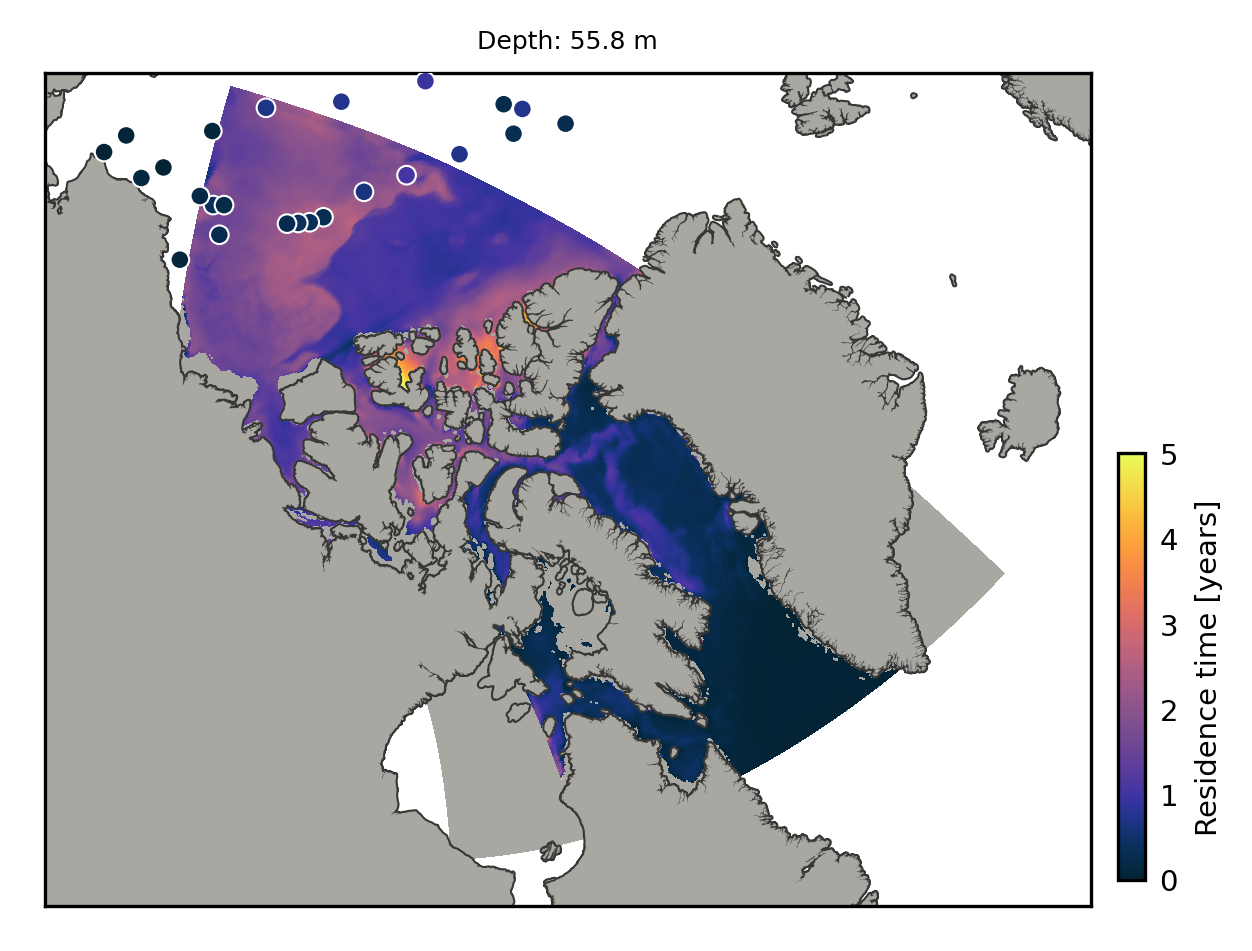

In [125]:
plot_layer(depth_weighted_restime5, 18, vmin=0, vmax=5)

#### Vertical variation in residence time

In [14]:
# Average basin profiles for different regions 
# --- Canada Basin ---
CB_mask  = np.zeros(bathy_masked.shape)
CB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CB_mask[depth][mesh_lon > -80]   = 0
    CB_mask[depth][hdept < 2000]     = 0

CB_mask[mesh_bathy < 0.1] = 0

# --- CAA ---
CAA_mask = np.zeros(bathy_masked.shape)
CAA_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CAA_mask[depth][hdept > 500]     = 0
    CAA_mask[depth][mesh_lon < -130] = 0
    CAA_mask[depth][mesh_lon > -40]  = 0
    CAA_mask[depth][mesh_lat < 65]   = 0
    CAA_mask[depth][(mesh_lat < 75) & (mesh_lon >-75)] = 0
    
CAA_mask[mesh_bathy < 0.1] = 0

# --- Baffin Bay ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0
    BB_mask[depth][mesh_lat <= 65]   = 0
    BB_mask[depth][mesh_lat > 80]    = 0

BB_mask[mesh_bathy < 0.1] = 0
    
# --- Labrador Sea ---
LS_mask  = np.zeros(bathy_masked.shape)
LS_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    LS_mask[depth][mesh_lon < -75]   = 0
    LS_mask[depth][mesh_lat > 65]    = 0
    LS_mask[depth][hdept < 2000]     = 0
    
LS_mask[mesh_bathy < 0.1] = 0

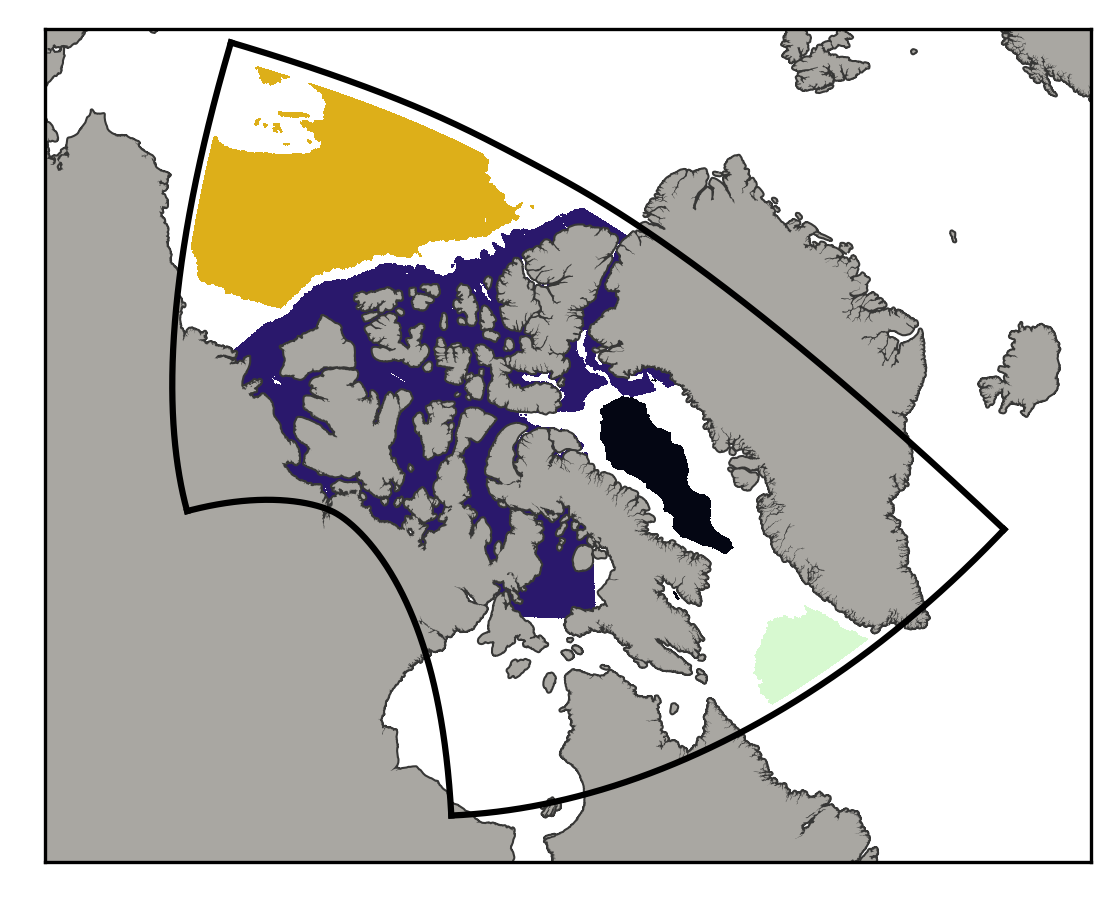

In [20]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

layer=0
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 

proj1.plot(x[:,0] ,y[:,0] ,'-k')
proj1.plot(x[:,-1],y[:,-1],'-k')
proj1.plot(x[0,:] ,y[0,:] ,'-k')
proj1.plot(x[-1,:],y[-1,:],'-k')

CB_mask_plot  = np.ma.masked_where(CB_mask < 1 , CB_mask)
CAA_mask_plot = np.ma.masked_where(CAA_mask < 1, CAA_mask)
BB_mask_plot  = np.ma.masked_where(BB_mask < 1 , BB_mask)
LS_mask_plot  = np.ma.masked_where(LS_mask < 1 , LS_mask)
proj1.pcolormesh(x, y, CB_mask_plot[layer,imin:imax,jmin:jmax] , cmap=cmocean.cm.oxy_r) 
proj1.pcolormesh(x, y, CAA_mask_plot[layer,imin:imax,jmin:jmax], cmap=cmocean.cm.haline)
proj1.pcolormesh(x, y, BB_mask_plot[layer,imin:imax,jmin:jmax] , cmap=cmocean.cm.ice) 
proj1.pcolormesh(x, y, LS_mask_plot[layer,imin:imax,jmin:jmax] , cmap=cmocean.cm.algae) 

In [15]:
def calc_regional_restime_profile(residence_time):
    
    # Separate based on region:
    CB_residence_time  = np.ma.masked_where(CB_mask[:,imin:imax,jmin:jmax]!=1 , residence_time)
    CAA_residence_time = np.ma.masked_where(CAA_mask[:,imin:imax,jmin:jmax]!=1, residence_time)
    BB_residence_time  = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]!=1 , residence_time)
    LS_residence_time  = np.ma.masked_where(LS_mask[:,imin:imax,jmin:jmax]!=1 , residence_time)

    # Calculate mean over each of the regions:
    CB_mean_restime    = np.ma.mean(CB_residence_time , axis=(1,2))
    CAA_mean_restime   = np.ma.mean(CAA_residence_time, axis=(1,2))
    BB_mean_restime    = np.ma.mean(BB_residence_time , axis=(1,2))
    LS_mean_restime    = np.ma.mean(LS_residence_time , axis=(1,2))

    return CB_mean_restime, CAA_mean_restime, BB_mean_restime, LS_mean_restime

In [141]:
def create_legend(axis, colors, markers):

    axis.set_xlim(-1,-0.5)
    axis.set_ylim(-1,-0.5)
    
    axis.plot([0,0], [0,0], '.', markeredgecolor='w', markeredgewidth=0.0, \
                     label=r'$\bf{Observations:}$', markersize=7, color='w')      
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Kadko et al., 2018; Arctic', markersize=3, color=g, marker=markers[0])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Henderson and Maier-Reimer, 2002; Atlantic', markersize=5, color=g, marker=markers[1])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Schaul and Patterson, 1981; N. Pacific', markersize=5, color=g, marker=markers[2])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Schaul and Patterson, 1983; Sargasso', markersize=5, color=g, marker=markers[3])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Bacon et al., 1976; Atlantic', markersize=5, color=g, marker=markers[4])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Chen et al., 2012; Chukchi Sea', markersize=5, color=g, marker=markers[5]) 
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Craig et al., 1973; Pacific', markersize=5, color=g, marker=markers[6])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Masque et al., 2002; Mediterranean Sea', markersize=5, color=g, marker=markers[7]) 
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Moore and Smith, 1986; Arctic', markersize=7, color=g, marker=markers[8])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Nozaki et al, 1976; Pacific', markersize=4, color=g, marker=markers[9])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='*Smith et al., 2003; Arctic', markersize=5, color=g, marker=markers[10]) 
    
    
    axis.plot([0,0], [0,0],'.', markeredgecolor='w', markeredgewidth=0.0, \
                     label='   ', markersize=7, color='w')
    axis.plot([0,0], [0,0],'.', markeredgecolor='w', markeredgewidth=0.0, \
                     label=r'$\bf{Scavenging\ Rate:}$', markersize=7, color='w')  
    
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 0.2 \cdot 10^{-5}\ s^{-1}$', color=colors[0])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 0.5 \cdot 10^{-5}\ s^{-1}$', color=colors[1])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 0.8 \cdot 10^{-5}\ s^{-1}$', color=colors[2])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.0 \cdot 10^{-5}\ s^{-1}$', color=colors[3])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.2 \cdot 10^{-5}\ s^{-1}$', color=colors[4])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.4 \cdot 10^{-5}\ s^{-1}$', color=colors[5])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.6 \cdot 10^{-5}\ s^{-1}$', color=colors[6])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.8 \cdot 10^{-5}\ s^{-1}$', color=colors[7])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 3.0 \cdot 10^{-5}\ s^{-1}$', color=colors[8])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 5.0 \cdot 10^{-5}\ s^{-1}$', color=colors[9])

    return

In [164]:
def plot_profiles(ax, residence_time, markers, scav_run=0, color='k'):
    
    CB_mean_restime, CAA_mean_restime, BB_mean_restime, LS_mean_restime = calc_regional_restime_profile(residence_time)
    
    restimes = [CB_mean_restime, CAA_mean_restime, BB_mean_restime, LS_mean_restime]        
        
    for n, axis in enumerate(ax.ravel()):
        axis.set_xlabel('Residence time [years]', fontsize=6)
        axis.tick_params(axis='both', labelsize=6)
        axis.xaxis.tick_top()
        axis.xaxis.set_label_position('top') 

        # Model: ---------------------------------------------------------------------------------
        axis.plot(restimes[n],  mesh_depth, '-', c=color) # CB
        
        # Observations: --------------------------------------------------------------------------
        axis.plot(kadko_res      , kadko_ave_depth   ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=3, color=g, marker=markers[0])
        axis.plot(HMR_restime    , HMR_ave_depth     ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[1])
        axis.plot(schaul1_restime, schaul1_ave_depth ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[2])
        axis.plot(schaul_restime , schaul_ave_depth  ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[3])
        axis.plot(Bacon_restime  , Bacon_ave_depth   ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[4])
        axis.plot(chen_res       , chen_ave_depth    ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[5])
        axis.plot(craig_restime  , craig_ave_depth   ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[6])
        axis.plot(masque_restime , masque_ave_depth  ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[7])  
        axis.plot(MS_restime     , MS_ave_depth      ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=7, color=g, marker=markers[8])
        axis.plot(nozaki_restime , nozaki_ave_depth  ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=4, color=g, marker=markers[9])
        axis.plot(smith_restime  , smith_ave_depth   ,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[10]) 
        
#         axis.errorbar(HMR_restime, HMR_ave_depth, xerr=HMR_restime_err, yerr=0, color=g)

        # RMSE: ---------------------------------------------------------------------------------
        # Residence time of model for depth indices that match the observations
        restime_model = np.array([restimes[n][int(ind)] for ind in all_model_depth_ind]) 
        # Calculate root-mean-square-error
        RMSE = calc_RMSE(restime_model, all_obs_restime)
        
        xmin, xmax = axis.get_xlim()
        ymin, ymax = axis.get_ylim()
        # add RMSE in color at bottom of figure
        if scav_run < 4:
            axis.text(xmax*0.05, ymin*(1.06 + scav_run/20), f'{RMSE:.1f}', c=color, fontsize=5)
        elif (scav_run >= 4) & (scav_run < 7):
            axis.text(xmax*1.1/4, ymin*(1.06 + (scav_run-3)/20), f'{RMSE:.1f}', c=color, fontsize=5)            
        elif (scav_run >= 7) & (scav_run < 10):
            axis.text(xmax*1/2, ymin*(1.06 + (scav_run-6)/20), f'{RMSE:.1f}', c=color, fontsize=5)
        else:
            axis.text(xmax*2.8/4, ymin*(1.06 + (scav_run-9)/20), f'{RMSE:.1f}', c=color, fontsize=5)
            
        if scav_run==1:
            axis.text(xmax*-0.20, ymin*(1.06 + scav_run/20), f'RMSE: ', c='k', fontsize=5)

    return

In [88]:
def calc_RMSE(restime_model, restime_obs):
    
    if len(restime_model) != len(restime_obs):
        return print('Lists are note equal length')
    else:
        residence_time_obs = np.array(restime_obs)
        residence_time_mod = np.array(restime_model)
        
        restime_observ = residence_time_obs[~np.isnan(residence_time_mod)]
        restime_models = residence_time_mod[~np.isnan(residence_time_mod)]
        
        N    = len(restime_observ)
        RMSE = np.ma.sqrt(np.ma.sum((restime_models - restime_observ)**2)/N)
    
        return RMSE

In [56]:
def match_depth(obs_depth):
    
    # Match nearest depth of observations to index in model:
    match_depth_model = np.empty(len(obs_depth))
    for d, depth in enumerate(obs_depth):
        match_depth_model[d] = np.argmin(np.abs(mesh_depth - depth))
    
    return match_depth_model

In [74]:
all_obs_ave_depth = []
all_obs_ave_depth.extend(kadko_ave_depth)
all_obs_ave_depth.extend(Bacon_ave_depth)
all_obs_ave_depth.extend(HMR_ave_depth)
all_obs_ave_depth.extend(MS_ave_depth)
all_obs_ave_depth.extend(craig_ave_depth)
all_obs_ave_depth.extend(nozaki_ave_depth)
all_obs_ave_depth.extend(schaul1_ave_depth)
all_obs_ave_depth.extend(schaul_ave_depth)
all_obs_ave_depth.extend(chen_ave_depth)
all_obs_ave_depth.extend(masque_ave_depth)
all_obs_ave_depth.extend(smith_ave_depth)

all_obs_restime = []
all_obs_restime.extend(kadko_res)
all_obs_restime.extend(Bacon_restime)
all_obs_restime.extend(HMR_restime)
all_obs_restime.extend(MS_restime)
all_obs_restime.extend(craig_restime)
all_obs_restime.extend(nozaki_restime)
all_obs_restime.extend(schaul1_restime)
all_obs_restime.extend(schaul_restime)
all_obs_restime.extend(chen_res)
all_obs_restime.extend(masque_restime)
all_obs_restime.extend(smith_restime)

In [57]:
all_model_depth_ind = match_depth(all_obs_ave_depth)

In [19]:
folder_base = '/data/brogalla/run_storage/Pb-tuning-202210/'
residence_time_scav1 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav1/', 2002)
residence_time_scav2 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav2/', 2002)
residence_time_scav3 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav3/', 2002)
residence_time_scav4 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav4/', 2002)
residence_time_scav5 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav5/', 2002)
residence_time_scav6 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav6/', 2002)
residence_time_scav7 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav7/', 2002)
residence_time_scav8 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav8/', 2002)
residence_time_scav9 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav9/', 2002)
residence_time_scav10 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav10/', 2002)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Wa

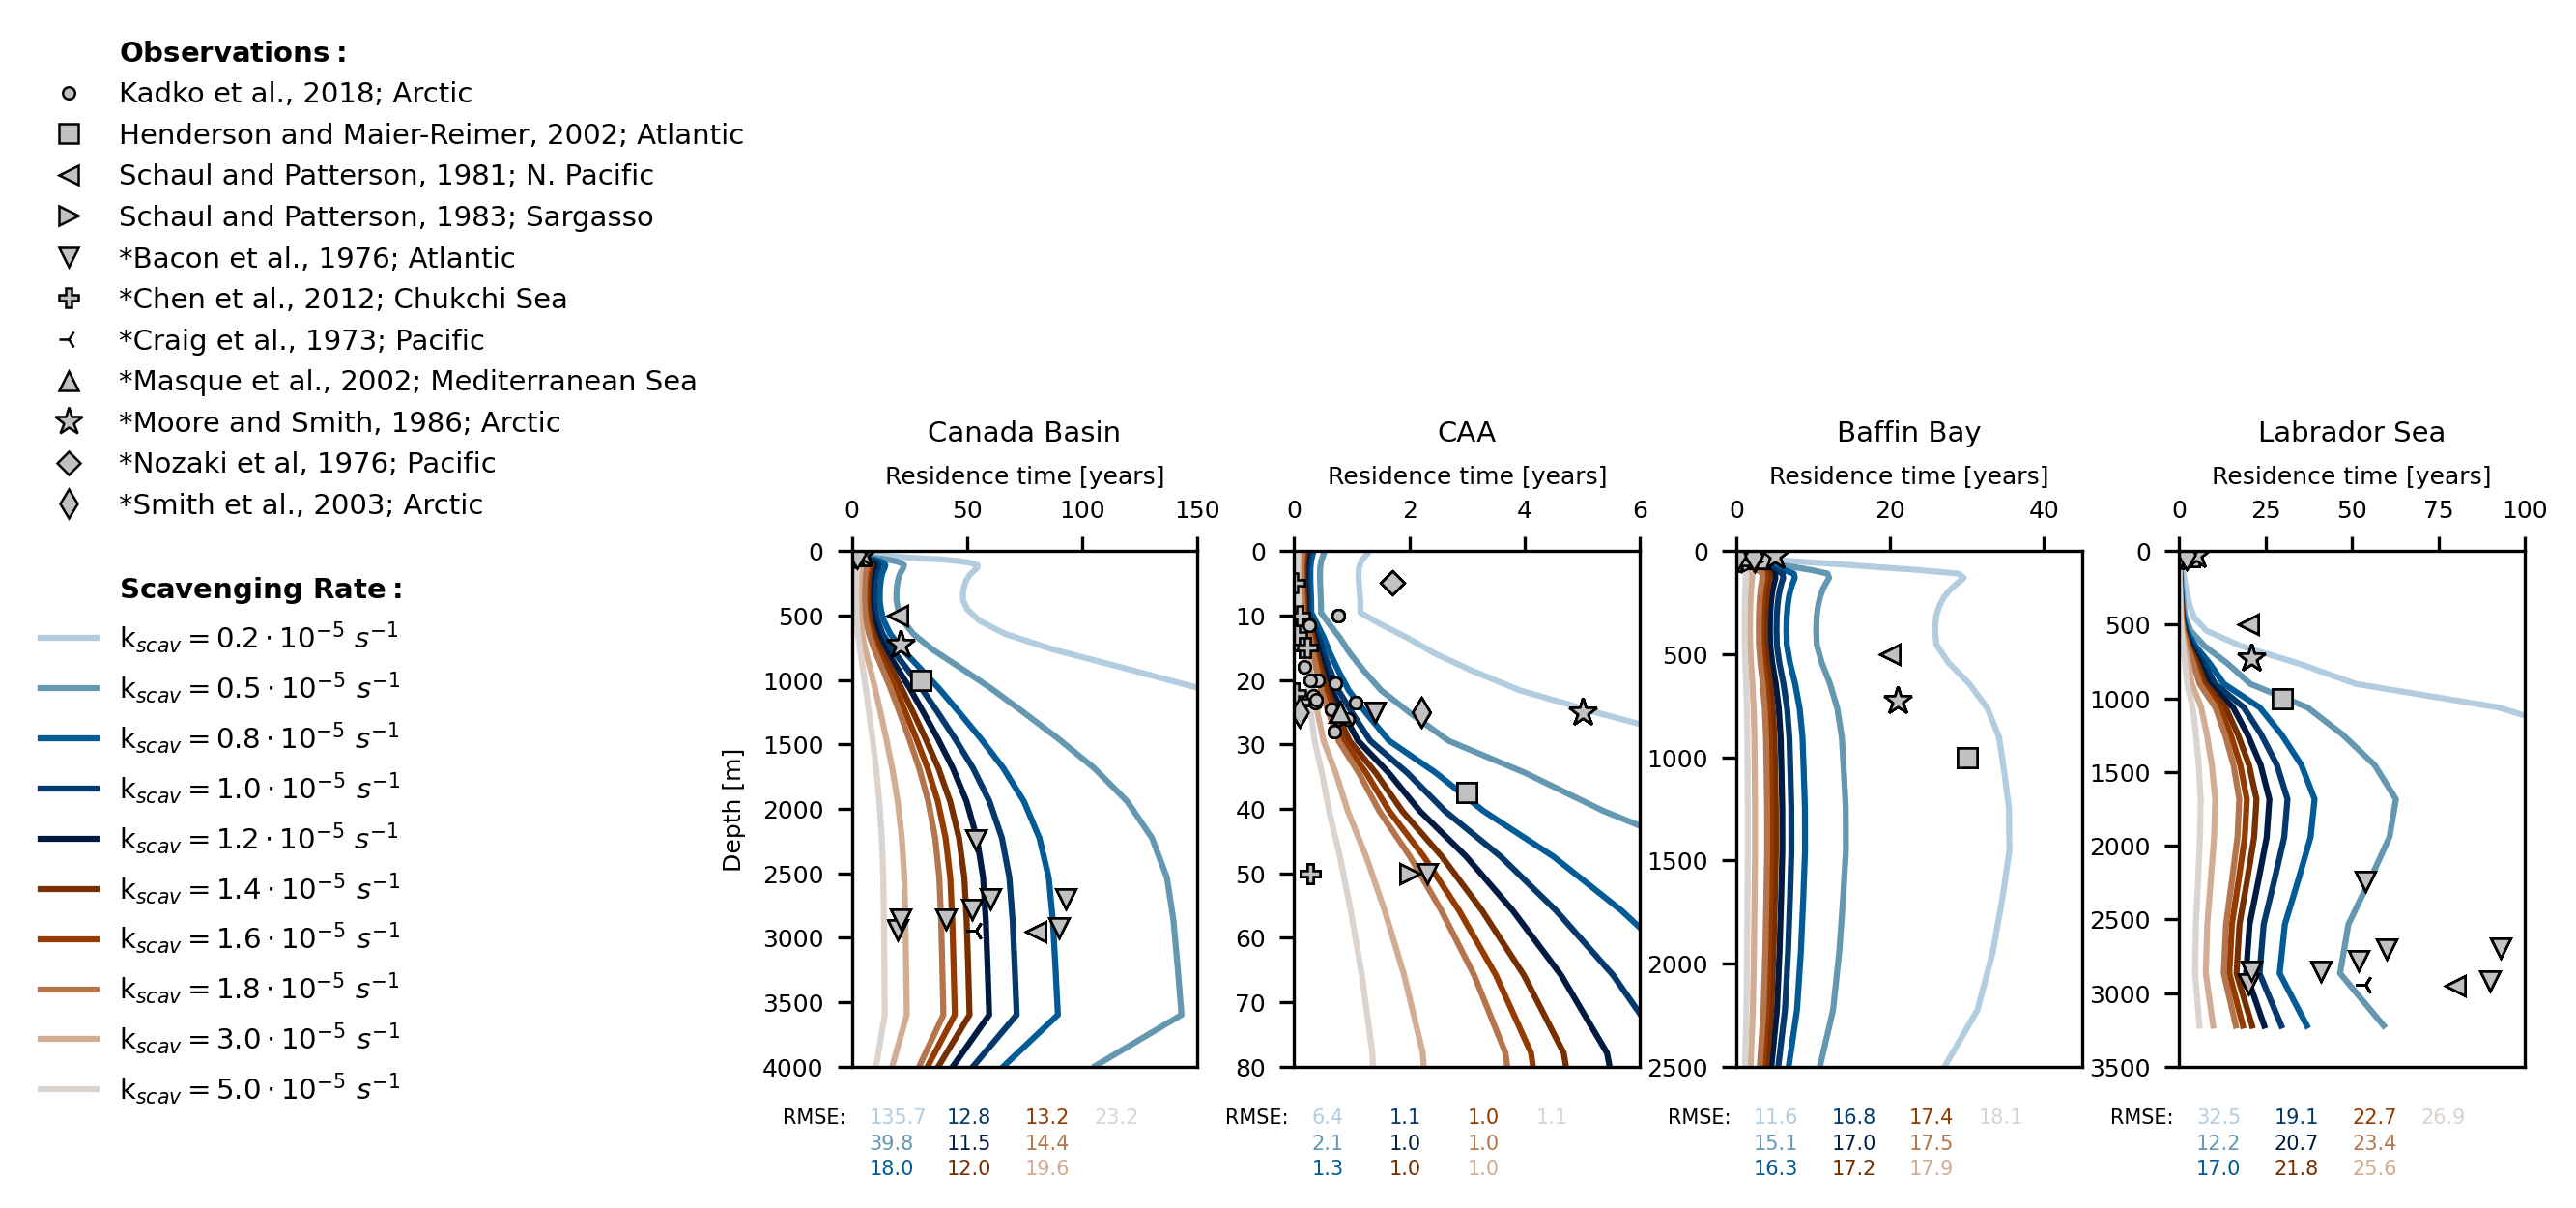

In [165]:
fig, ax = plt.subplots(1, 5, figsize=(9,3.5), dpi=300)

ax[0].axis('off')
ax[1].set_ylabel('Depth [m]', fontsize=6)
ax[1].set_title('Canada Basin', fontsize=7)
ax[2].set_title('CAA', fontsize=7)
ax[3].set_title('Baffin Bay', fontsize=7)
ax[4].set_title('Labrador Sea', fontsize=7)

markers  = ["o","s","<",">","v","P","3","^","*","D", "d"]
colors   = ['#b3cde0','#6497b1','#005b96','#03396c','#001b43','#782f00', '#963b00','#b5754c','#d2ac93','#dbd3ce']

# ax[1].set_ylim(100,0);  ax[1].set_xlim(0,1);
# ax[2].set_ylim(100,0);  ax[2].set_xlim(0,1);
ax[1].set_ylim(4000,0);  ax[1].set_xlim(0,150);
ax[2].set_ylim(80,0);  ax[2].set_xlim(0,6);
ax[3].set_ylim(2500,0); ax[3].set_xlim(0,45);
ax[4].set_ylim(3500,0);  ax[4].set_xlim(0,100);

create_legend(ax[0], colors, markers)
plot_profiles(ax[1:5], residence_time_scav1, markers, scav_run=1, color=colors[0])
plot_profiles(ax[1:5], residence_time_scav2, markers, scav_run=2, color=colors[1])
plot_profiles(ax[1:5], residence_time_scav3, markers, scav_run=3, color=colors[2])
plot_profiles(ax[1:5], residence_time_scav4, markers, scav_run=4, color=colors[3])
plot_profiles(ax[1:5], residence_time_scav5, markers, scav_run=5, color=colors[4])
plot_profiles(ax[1:5], residence_time_scav6, markers, scav_run=6, color=colors[5])
plot_profiles(ax[1:5], residence_time_scav7, markers, scav_run=7, color=colors[6])
plot_profiles(ax[1:5], residence_time_scav8, markers, scav_run=8, color=colors[7])
plot_profiles(ax[1:5], residence_time_scav9, markers, scav_run=9, color=colors[8])
plot_profiles(ax[1:5], residence_time_scav10, markers, scav_run=10, color=colors[9])

ax[0].legend(loc=(-1.1, -0.1), fontsize=7, frameon=False)

plt.tight_layout(w_pad=-0.8)

Asterisks indicate Pb-210 based estimates.

Add plot of all profiles on one scale.

Profiles show strong variation between regions when you plot them on the same axis scales, with strongest removal in the Labrador Sea, weakest in the Canada Basin, then CAA, Baffin Bay. The differences between CB, CAA, and BB are most obvious below 100 m, while LS is apparent everywhere.